In [ ]:
!pip install gluonts
!pip install autogluon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to 

In [ ]:
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.evaluation.metrics import mse
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short.csv')
df = df[df.unique_id == "BE"]
df

,unique_id,ds,y
0,BE,2016-10-22 00:00:00,70.00
1,BE,2016-10-22 01:00:00,37.10
2,BE,2016-10-22 02:00:00,37.10
3,BE,2016-10-22 03:00:00,44.75
4,BE,2016-10-22 04:00:00,37.10
...,...,...,...
1675,BE,2016-12-30 19:00:00,57.42
1676,BE,2016-12-30 20:00:00,57.56
1677,BE,2016-12-30 21:00:00,52.18
1678,BE,2016-12-30 22:00:00,54.38


In [ ]:
# Initialize variables
historical_days = 35
window_size = 24 * historical_days  # 24 hours a day
prediction_length = 24  # Predict 24 hours

pred_dict = {}
actual_dict = {}
best_model_name = []

# Iterate through the time series data by rolling window
for start_idx in range(len(df) - window_size):
    # Slice the data for the current rolling window
    rolling_window = df.iloc[start_idx : start_idx + window_size]

    # Convert rolling_window to a TimeSeriesDataFrame
    train_data = TimeSeriesDataFrame.from_data_frame(
        rolling_window,
        id_column='unique_id',  # Specify the item_id column
        timestamp_column='ds'  # Specify the timestamp column
    )

    # Fit the TimeSeriesPredictor on the rolling window
    predictor = TimeSeriesPredictor(
        prediction_length=prediction_length,
        path="multiple-timeseries/electric-hourly-5week_rollingwindow",
        freq="H",
        target="y",
        eval_metric="MSE",
    )
    predictor.fit(train_data, presets="fast_training", random_seed=42)

    # Predict the next hour
    prediction = predictor.predict(train_data, random_seed=42)

    # Add the predictions to the list
    pred_dict[df.iloc[start_idx + window_size].ds] = prediction['mean'].to_list()
    actual_dict[df.iloc[start_idx + window_size].ds] = df.iloc[start_idx + window_size].y

    best_model_name.append(predictor.info()["best_model"])

Streaming output truncated to the last 5000 lines.
	0.32    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. 
	-193.8171     = Validation score (-MSE)
	10.06   s     = Training runtime
	0.14    s     = Validation (prediction) runtime
Training timeseries model ETS. 
	-212.0406     = Validation score (-MSE)
	0.02    s     = Training runtime
	0.60    s     = Validation (prediction) runtime
Training timeseries model Theta. 
	-174.4292     = Validation score (-MSE)
	0.02    s     = Training runtime
	0.11    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'DirectTabular': 0.33, 'ETS': 0.28, 'SeasonalNaive': 0.39}
	-74.0928      = Validation score (-MSE)
	0.70    s     = Training runtime
	0.75    s     = Validation (prediction) runtime
Training complete. Models trained: ['Naive', 'SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'ETS', 'Theta', 'WeightedEnsemble']
Total runtime: 14.31 s
Best model: WeightedEnsem

In [ ]:
# Assuming pred_dict is defined as in the original code
# Create an empty list to store the data for the DataFrame
data_pred = []

# Iterate through the pred_dict
for date, predictions in pred_dict.items():
  # Create a dictionary for each date's predictions
  row = {'time': date}
  for i, pred in enumerate(predictions):
    row[f'step{i+1}'] = pred
  data_pred.append(row)

# Create the DataFrame
pred_df = pd.DataFrame(data_pred)

actual_df = pd.DataFrame(list(actual_dict.items()), columns=['time', 'actual'])

# Convert 'time' column to datetime objects if they are not already
actual_df['time'] = pd.to_datetime(actual_df['time'])
pred_df['time'] = pd.to_datetime(pred_df['time'])

# Merge the DataFrames on the 'time' column
merged_df = pd.merge(actual_df, pred_df, on='time', how='inner')
merged_df['best_model'] = best_model_name
merged_df

,time,actual,step1,step2,step3,step4,step5,step6,step7,step8,...,step16,step17,step18,step19,step20,step21,step22,step23,step24,best_model
0,2016-11-26 00:00:00,42.44,34.136799,30.735601,29.462610,29.273273,29.702847,32.049180,41.792309,54.537599,...,54.336922,55.682967,59.301536,60.438119,58.893044,51.673864,47.056227,46.753666,45.282118,WeightedEnsemble
1,2016-11-26 01:00:00,32.79,34.043376,33.286586,32.196433,32.040928,34.930419,44.243462,55.624554,60.666263,...,56.018823,59.455756,61.084451,59.772425,53.093164,48.793343,47.567254,44.928214,39.768751,WeightedEnsemble
2,2016-11-26 02:00:00,34.56,32.418948,31.004106,31.011837,33.283636,42.837874,55.553899,61.138541,60.004179,...,59.736257,61.824996,59.996888,53.731913,50.161658,48.647405,46.129125,40.608325,32.453235,WeightedEnsemble
3,2016-11-26 03:00:00,34.70,31.068326,30.871308,33.545071,42.771902,55.972964,62.236689,60.862098,58.387557,...,62.557972,61.052523,54.510621,50.522400,49.036340,46.353631,41.177723,32.678855,33.722373,WeightedEnsemble
4,2016-11-26 04:00:00,33.00,31.329874,33.372430,42.780692,55.629947,61.272010,60.107708,57.695593,56.966900,...,60.416890,54.183859,50.565457,48.741557,46.426235,41.092522,32.630389,33.900786,33.336338,WeightedEnsemble
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,2016-12-30 19:00:00,57.42,57.769859,52.249514,46.481013,47.361372,45.669180,42.535342,40.682234,39.896304,...,54.626614,53.655826,51.903828,50.480588,49.543260,50.523100,52.631959,59.943872,64.428267,WeightedEnsemble
836,2016-12-30 20:00:00,57.56,52.779011,47.120952,48.012410,46.695914,44.261035,42.535161,41.762979,40.635718,...,54.571668,52.998000,51.597415,50.646686,51.719730,53.935602,60.803591,64.436823,58.219217,WeightedEnsemble
837,2016-12-30 21:00:00,52.18,52.992549,54.824070,52.489279,52.060131,51.561418,49.692991,49.206454,48.327013,...,58.424879,55.609865,56.377947,58.420898,61.117076,68.341669,67.583567,63.707646,61.991856,WeightedEnsemble
838,2016-12-30 22:00:00,54.38,52.832614,51.234532,49.634538,48.702828,47.208080,46.384091,45.912159,47.284262,...,54.963542,55.358748,57.273033,59.605398,66.803742,67.136020,62.794500,60.002708,55.542726,WeightedEnsemble


In [ ]:
#merged_df.to_pickle('/content/drive/My Drive/autogluon_elec_BE_C5w_P1h_pred.pkl')

In [ ]:
import pandas as pd

#Predictions from Auto-gluon
pred_autogluon = pd.read_pickle('/content/drive/My Drive/autogluon_elec_BE_C5w_P1h_pred.pkl')
pred_autogluon.drop(columns = ['actual'], inplace = True)

#predictions from Lag-LLama model
pred_lagllama = pd.read_pickle('/content/drive/My Drive/lag_llama_elec_BE_C5w_P24h_pred.pkl')

# Merge the two dataframes
merged_df = pd.merge(pred_lagllama, pred_autogluon, on='time', suffixes=('_lagllama', '_autogluon'))

In [ ]:
from sklearn.metrics import mean_squared_error

# Initialize list to store the differences
mse_lagllama = []
mse_autogluon = []
mse_avg = []
mse_04l_06a = []
mse_025l_075a = []
mse_075l_025a = []
mse_max = []
mse_min = []

# Loop through the prediction steps (1 to 24)
for x in range(1, 25):
    # Calculate the differences
    temp = merged_df.copy()
    temp['actual_lag'] = merged_df['actual'].shift(-x+1)
    temp['avg'] = (merged_df[f'step{x}_lagllama'] + merged_df[f'step{x}_autogluon']) / 2
    temp['0.4l_0.6a'] = merged_df[f'step{x}_lagllama'] * 0.4 + merged_df[f'step{x}_autogluon'] * 0.6
    temp['0.25l_0.75a'] = merged_df[f'step{x}_lagllama'] * 0.25 + merged_df[f'step{x}_autogluon'] * 0.75
    temp['0.75l_0.25a'] = merged_df[f'step{x}_lagllama'] * 0.75 + merged_df[f'step{x}_autogluon'] * 0.25
    #temp_max = merged_df[[f'step{x}_lagllama', f'step{x}_autogluon']].max(axis=1)
    #temp_min = merged_df[[f'step{x}_lagllama', f'step{x}_autogluon']].min(axis=1)

    if x == 1:
      temp2 = temp
    else:
      temp2 = temp.iloc[:(-x+1)]

    mse_lagllama.append(mean_squared_error(temp2[f'step{x}_lagllama'], temp2['actual_lag']))
    mse_autogluon.append(mean_squared_error(temp2[f'step{x}_autogluon'], temp2['actual_lag']))
    mse_avg.append(mean_squared_error(temp2['avg'], temp2['actual_lag']))
    mse_04l_06a.append(mean_squared_error(temp2['0.4l_0.6a'], temp2['actual_lag']))
    mse_025l_075a.append(mean_squared_error(temp2['0.25l_0.75a'], temp2['actual_lag']))
    mse_075l_025a.append(mean_squared_error(temp2['0.75l_0.25a'], temp2['actual_lag']))

    """
    mse_lagllama.append(np.nanmean(merged_df[f'step{x}_lagllama'] - temp_actual_lag)**2)
    mse_autogluon.append(np.nanmean(merged_df[f'step{x}_autogluon'] - temp_actual_lag)**2)
    mse_avg.append(np.nanmean(temp_avg - temp_actual_lag)**2)
    mse_max.append(np.nanmean(temp_max - temp_actual_lag)**2)
    mse_min.append(np.nanmean(temp_min - temp_actual_lag)**2)
    """

print(f"MSE for LagLLama: {mse_lagllama}")
print(f"MSE for AutoGluon: {mse_autogluon}")
print(f"MSE for Average Difference: {mse_avg}")
#print(f"MSE for Max Difference: {mse_max}")
#print(f"MSE for Min Difference: {mse_min}")


MSE for LagLLama: [488.7596130371094, 504.7275085449219, 526.0968017578125, 545.7392578125, 553.4888305664062, 572.4393920898438, 577.8372192382812, 590.0570678710938, 590.2236938476562, 591.3583984375, 588.05126953125, 602.7346801757812, 610.7767333984375, 607.8917236328125, 609.2015991210938, 613.1748657226562, 609.3876342773438, 622.092041015625, 621.2587890625, 611.2225341796875, 612.9622802734375, 617.8143920898438, 618.3271484375, 613.3860473632812]
MSE for AutoGluon: [203.6711264286664, 247.35724934973504, 280.31111244037385, 300.8392092175968, 321.1764845844366, 332.2419146287421, 340.32128015865663, 344.05297457619776, 350.8207838903648, 366.6000110356039, 388.36157337961106, 419.50528949333574, 413.9152555901349, 435.1334430840632, 465.771130644136, 456.230130126773, 456.8245509837026, 480.4227875510198, 480.8857111265802, 470.7750499600214, 459.59751448731345, 436.14650343845767, 438.84245783750777, 452.51549913543187]
MSE for Average Difference: [265.52264476998414, 286.906

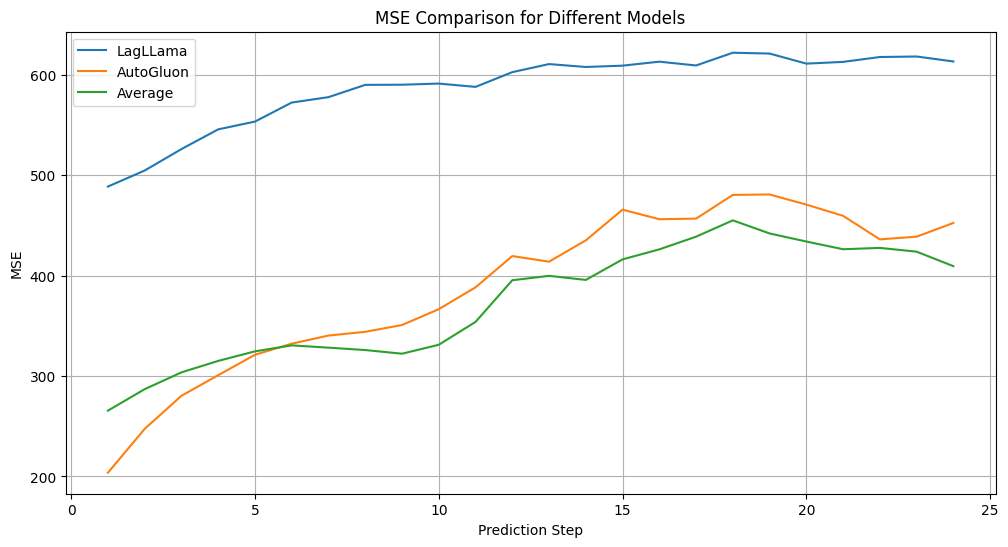

In [ ]:
# Assuming mse_lagllama, mse_autogluon, mse_avg, mse_max, and mse_min are defined as in the previous code
x_axis = list(range(1, 25))

plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(x_axis, mse_lagllama, label='LagLLama')
plt.plot(x_axis, mse_autogluon, label='AutoGluon')
plt.plot(x_axis, mse_avg, label='Average')

plt.xlabel('Prediction Step')
plt.ylabel('MSE')
plt.title('MSE Comparison for Different Models')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

mse_cv_min_step = []
mse_cv_max_step = []
mse_cv_avg_step = []
mse_train_step = []
mse_test_step = []
mse_overall_step = []
coeff_lagllama_step = []
coeff_autogluon_step = []

for x in range(1, 25):
  # Prepare the data for the regression model
  if x == 1:
    X = merged_df[[f'step{x}_lagllama', f'step{x}_autogluon']]
    y = merged_df['actual']
  else:
    X = merged_df[[f'step{x}_lagllama', f'step{x}_autogluon']].iloc[:(-x+1)]
    y = merged_df['actual'].shift(-x+1).iloc[:(-x+1)]

  # Split the data into training and testing sets
  X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False) # Important: shuffle=False to maintain time order

  # Define the time series cross-validation
  tscv = TimeSeriesSplit(n_splits=5)

  # Initialize lists to store results
  mse_scores = []

  # Perform cross-validation
  for train_index, val_index in tscv.split(X_cv):
      X_train, X_val = X_cv.iloc[train_index], X_cv.iloc[val_index]
      y_train, y_val = y_cv.iloc[train_index], y_cv.iloc[val_index]

      # Initialize and train the linear regression model
      model = LinearRegression(fit_intercept = False)
      model.fit(X_train, y_train)

      # Make predictions on the test set
      y_val_pred = model.predict(X_val)

      # Calculate MSE and store results
      mse = mean_squared_error(y_val, y_val_pred)
      mse_scores.append(mse)

  # Print the average MSE across all folds
  avg_mse = np.mean(mse_scores)
  min_mse = np.min(mse_scores)
  max_mse = np.max(mse_scores)
  mse_cv_avg_step.append(avg_mse)
  mse_cv_min_step.append(min_mse)
  mse_cv_max_step.append(max_mse)
  #print(f"Average MSE across folds: {avg_mse}")

  #train model on overall train data (cv)
  model = LinearRegression(fit_intercept = False)
  model.fit(X_cv, y_cv)

  coefficients = model.coef_
  coeff_lagllama_step.append(coefficients[0])
  coeff_autogluon_step.append(coefficients[1])

  #mse on overall data
  y_cv_pred = model.predict(X_cv)
  mse_train = mean_squared_error(y_cv, y_cv_pred)
  #print(f"MSE on overall train data: {mse_train}")
  mse_train_step.append(mse_train)

  #test the model on test data
  y_test_pred = model.predict(X_test)
  mse_test = mean_squared_error(y_test, y_test_pred)
  mse_test_step.append(mse_test)
  #print(f"MSE on test data: {mse_test}")

  #mse on complete data
  y_pred = model.predict(X)
  mse_overall = mean_squared_error(y, y_pred)
  mse_overall_step.append(mse_overall)
  #print(f"MSE on complete data: {mse_overall}")

In [ ]:
import pandas as pd
# Create a DataFrame from the lists
coeff_df = pd.DataFrame({
    'step': range(1, 25),
    'coeff_lagllama': coeff_lagllama_step,
    'coeff_autogluon': coeff_autogluon_step
})

coeff_df.to_pickle('/content/drive/My Drive/be_ensemble_coeff_5w.pkl')

In [ ]:
print(f"mse_overall_step: {mse_overall_step}")
print(f"coeff_lagllama_step: {coeff_lagllama_step}")
print(f"coeff_autogluon_step: {coeff_autogluon_step}")

mse_overall_step: [196.57638014103773, 235.1270936269113, 261.00783243171594, 275.3036573465245, 289.8383911607124, 295.4116641716535, 295.4783465978378, 293.04955151778665, 292.5831635912138, 304.1436168501177, 330.4367169307034, 372.7000681868166, 374.354156214238, 376.546570793378, 402.0251145978793, 409.2131534778041, 421.20130196567897, 439.60680560711296, 427.83084055689676, 419.72083345343896, 409.51680852115913, 403.4280645991198, 400.6760009676787, 392.6009761866877]
coeff_lagllama_step: [np.float64(0.00534365860949367), np.float64(0.08234585051388353), np.float64(0.13938040068456134), np.float64(0.16263524972454238), np.float64(0.1892596494502649), np.float64(0.19727659989087254), np.float64(0.21556611970209413), np.float64(0.22688915024755654), np.float64(0.24577497079926602), np.float64(0.2561281794547657), np.float64(0.26411707037902477), np.float64(0.2540074789825621), np.float64(0.23559753451782345), np.float64(0.2878691873394529), np.float64(0.318936927658262), np.float

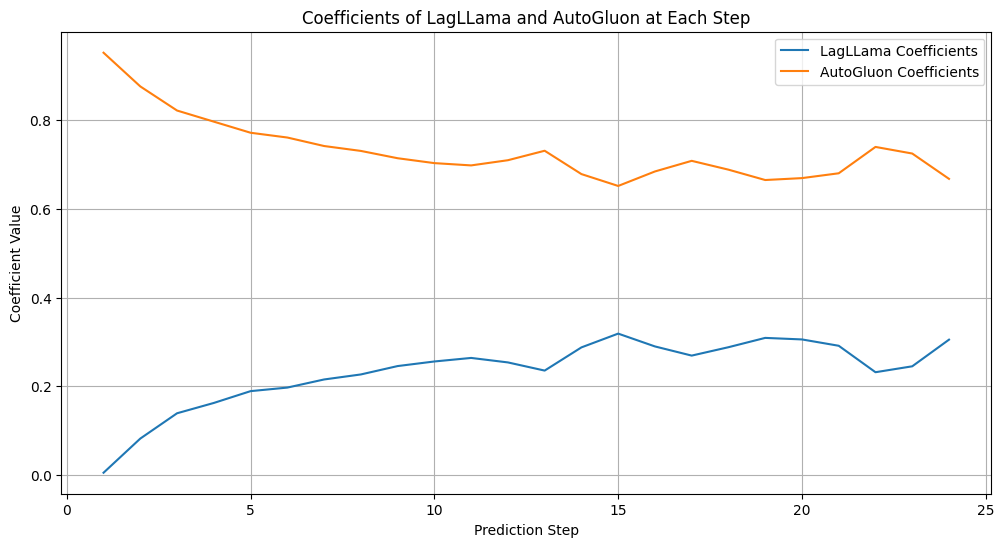

In [ ]:
#plot the co-efficients as line plot for lagllama and autogluon at each step
x_axis = list(range(1, 25))

plt.figure(figsize=(12, 6))
plt.plot(x_axis, coeff_lagllama_step, label='LagLLama Coefficients')
plt.plot(x_axis, coeff_autogluon_step, label='AutoGluon Coefficients')

plt.xlabel('Prediction Step')
plt.ylabel('Coefficient Value')
plt.title('Coefficients of LagLLama and AutoGluon at Each Step')
plt.legend()
plt.grid(True)
plt.show()

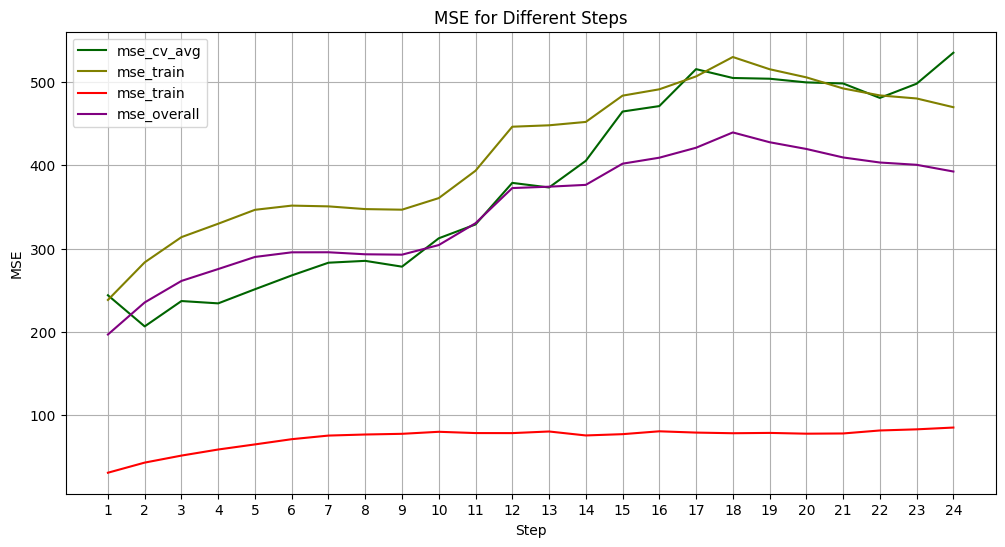

In [ ]:
# Create the plot
plt.figure(figsize=(12, 6))

#plt.fill_between(range(1,25), mse_cv_min_step, mse_cv_max_step, color='lightgreen', alpha=0.2)
plt.plot(range(1, 25), mse_cv_avg_step, color='darkgreen', label='mse_cv_avg')
plt.plot(range(1, 25), mse_train_step, color='olive', label='mse_train')
plt.plot(range(1, 25), mse_test_step, color='red', label='mse_train')
plt.plot(range(1, 25), mse_overall_step, color='purple', label='mse_overall')

# Customize the plot
plt.xlabel('Step')
plt.ylabel('MSE')
plt.title('MSE for Different Steps')
plt.legend()
plt.grid(True)
plt.xticks(range(1, 25))
plt.show()

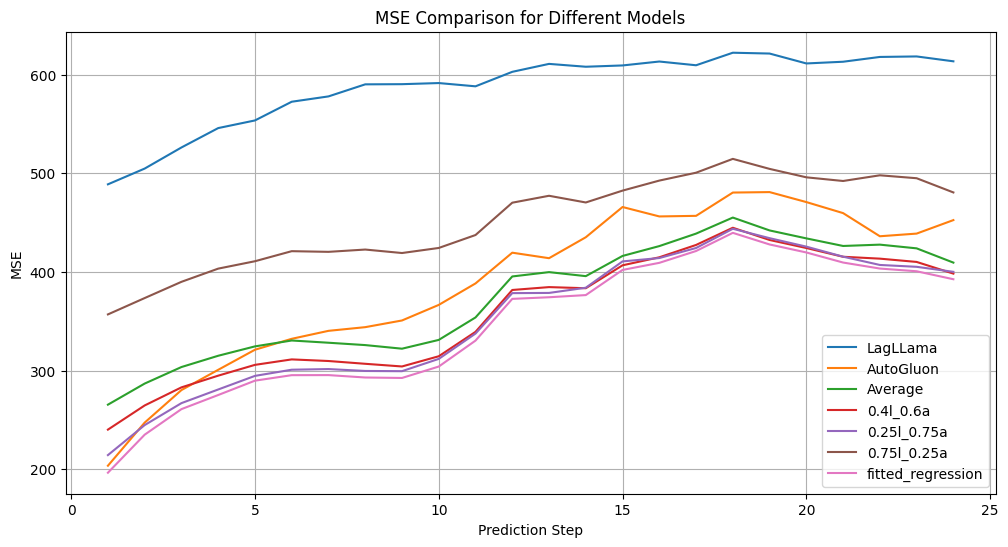

In [ ]:
import matplotlib.pyplot as plt

# Assuming mse_lagllama, mse_autogluon, mse_avg, mse_max, and mse_min are defined as in the previous code
x_axis = list(range(1, 25))

plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(x_axis, mse_lagllama, label='LagLLama')
plt.plot(x_axis, mse_autogluon, label='AutoGluon')
plt.plot(x_axis, mse_avg, label='Average')
plt.plot(x_axis, mse_04l_06a, label='0.4l_0.6a')
plt.plot(x_axis, mse_025l_075a, label='0.25l_0.75a')
plt.plot(x_axis, mse_075l_025a, label='0.75l_0.25a')
plt.plot(x_axis, mse_overall_step, label='fitted_regression')
#plt.plot(x_axis, mse_max, label='Max')
#plt.plot(x_axis, mse_min, label='Min')

plt.xlabel('Prediction Step')
plt.ylabel('MSE')
plt.title('MSE Comparison for Different Models')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
week1 = pd.read_pickle('/content/drive/My Drive/be_ensemble_coeff_1w.pkl')
week3 = pd.read_pickle('/content/drive/My Drive/be_ensemble_coeff_1w.pkl')
week5 = pd.read_pickle('/content/drive/My Drive/be_ensemble_coeff_1w.pkl')

In [ ]:
# prompt: join week1, week3, week5 on step

import pandas as pd
week1 = pd.read_pickle('/content/drive/My Drive/be_ensemble_coeff_1w.pkl')
week3 = pd.read_pickle('/content/drive/My Drive/be_ensemble_coeff_3w.pkl')
week5 = pd.read_pickle('/content/drive/My Drive/be_ensemble_coeff_5w.pkl')

# Rename columns to avoid duplicates after merging
week1 = week1.rename(columns={"coeff_lagllama": "coeff_lagllama_week1", "coeff_autogluon": "coeff_autogluon_week1"})
week3 = week3.rename(columns={"coeff_lagllama": "coeff_lagllama_week3", "coeff_autogluon": "coeff_autogluon_week3"})
week5 = week5.rename(columns={"coeff_lagllama": "coeff_lagllama_week5", "coeff_autogluon": "coeff_autogluon_week5"})

# Merge the dataframes on the 'step' column
merged_weeks = pd.merge(week1, week3, on='step', how='inner')
merged_weeks = pd.merge(merged_weeks, week5, on='step', how='inner')

merged_weeks.drop(columns = ['step'], inplace = True)


In [ ]:
merged_weeks

,coeff_lagllama_week1,coeff_autogluon_week1,coeff_lagllama_week3,coeff_autogluon_week3,coeff_lagllama_week5,coeff_autogluon_week5
0,0.332125,0.601680,0.404662,0.578614,0.005344,0.952155
1,0.448116,0.471027,0.465180,0.534136,0.082346,0.876162
2,0.451454,0.456282,0.509311,0.489959,0.139380,0.821817
3,0.423607,0.476178,0.482038,0.514523,0.162635,0.796770
4,0.387868,0.516094,0.492347,0.502000,0.189260,0.771744
5,0.366428,0.541459,0.512842,0.487044,0.197277,0.760975
6,0.386173,0.518859,0.463390,0.525784,0.215566,0.741829
7,0.379898,0.526257,0.460277,0.529347,0.226889,0.730793
8,0.371221,0.534776,0.471524,0.522355,0.245775,0.714312
9,0.396490,0.515927,0.483771,0.513617,0.256128,0.703277
